In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa.core as lc
import IPython.display as ipd

import dataset_loader.music_loader_stft

In [2]:
loader = dataset_loader.music_loader_stft.MusicLoaderSTFT('data/fma_xs', split='train')

(257, 126) 40.051105 1.3491033e-06 0.3927188 1.2315139
ft shape (257, 126)


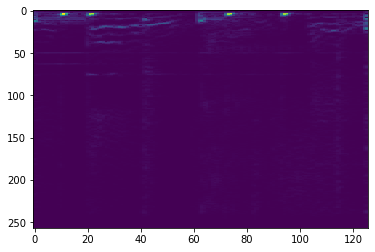

In [14]:
i = np.random.randint(len(loader))
sampling_rate = 8000

input_data = loader[i]
a = np.squeeze(input_data, axis=0)
print(a.shape, a.max(), a.min(), a.mean(), a.std())

plt.imshow(a, aspect='auto')
print('ft shape', a.shape)

In [4]:
# Original audio

signal = loader.get_raw(i)
ipd.Audio(signal, rate=sampling_rate)

In [5]:
# Reconstructed from STFT, with phase information from original data

#reconstruct = loader.spec_to_audio(a, i)
#ipd.Audio(reconstruct, rate=sampling_rate)

In [6]:
# Reconstructed from STFT, with phase information from original data

a[0, :] = 0

reconstruct_no_phase = loader.spec_to_audio(a)
ipd.Audio(reconstruct_no_phase, rate=sampling_rate)

spectrogram shape (257, 126)


In [7]:
reconstruct_no_phase = loader.spec_to_audio(a)
ipd.Audio(reconstruct_no_phase, rate=sampling_rate)

spectrogram shape (257, 126)


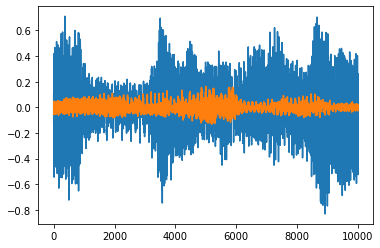

In [8]:
# Plot original vs reconstructed

plt.plot(signal[:10000])
plt.plot(reconstruct_no_phase[:10000])

In shape torch.Size([1, 1, 257, 126]) latent torch.Size([1, 32, 62, 30]) out shape torch.Size([1, 1, 257, 126])
0.8788092732429504
input mean, std 1.0070403 2.78961
output mean, std 1.0530316 2.4615266


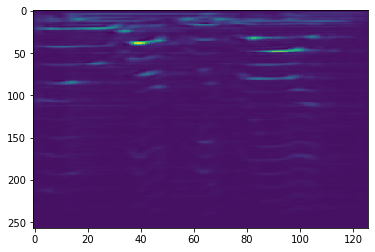

In [9]:
import os
import torch.utils
from torch.autograd import Variable
from models.frequency_autoencoder import FrequencyAutoencoder
from dataset_loader.music_loader_stft import MusicLoaderSTFT

data_dir = 'data/fma_xs/'
model_dir = 'model_logs/'

model = FrequencyAutoencoder()
model.cuda()

test_dataset = MusicLoaderSTFT(data_dir, split='test')
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

input_tensor = torch.from_numpy(np.expand_dims(input_data, axis=0))

input_tensor = Variable(input_tensor).cuda()
output_tensor = model.forward(input_tensor)
loss = float(model.loss_criterion(input_tensor, output_tensor))

print(loss)

output = output_tensor.cpu().data.numpy()
output = output.squeeze()

plt.imshow(output, aspect='auto')

print("input mean, std", input_data.mean(), input_data.std())
print("output mean, std", output.mean(), output.std())

In [10]:
reconstruct_no_phase = loader.spec_to_audio(output)
ipd.Audio(reconstruct_no_phase, rate=sampling_rate)

spectrogram shape (257, 126)
